<a href="https://colab.research.google.com/github/JishnuJayaraj/Machine-Learning/blob/master/NLP/SentenceClassification/Simple_Transformers_CoLA_Sentence_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Transformers - CoLA Sentence Classification

By Chris McCormick

This Notebook is a port of the original "Fine-Tuning BERT for Sentence Classification" tutorial that Nick and I published in 2019 ([blog post](http://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Notebook](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX)) to use the `Simple Transformers` library.

This version has less comments and explanation than my typical Notebooks--the goal was just to get a quick sense of the `Simple Transformers` library.



# Contents

See "Table of contents" in the sidebar to the left.

# S1. Setup

## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


## 1.2. Installing Simple Transformers



* Install Simple Transformers
* Seeing some disconcerting errors...

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 215kB 10.0MB/s 
     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 1.7MB 15.6MB/s 
     |████████████████████████████████| 7.2MB 51.8MB/s 
     |████████████████████████████████| 317kB 45.2MB/s 
     |████████████████████████████████| 1.1MB 46.0MB/s 
     |████████████████████████████████| 3.0MB 46.2MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
     |████████████████████████████████| 163kB 52.1MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 122kB 55.7MB/s 
     |████████████████████████████████| 112kB 49.7MB/s 
     |████████████████████████████████| 102kB 12.1MB/s 
     |████████████████████████████████| 6.7MB 44.6MB/s 
     |████████████████████████████████| 4.4MB 52.8MB/s 
     |████████████████████████████████| 1.1MB 46.2MB/s 
     |████████████████████████████████| 890kB 48.8MB/s 
     |████████████████████████████████| 71kB 9.8MB

# S2. Loading CoLA Dataset


We'll use [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE Benchmark" on which models like BERT are competing.


## 2.1. Download & Extract

We'll use the `wget` package to download the dataset to the Colab instance's file system. 

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=b9850d2c084707d0bad1d2f47efce88550331b0f99b57f2f68b9fd31c43af641
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


The dataset is hosted on GitHub in this repo: https://nyu-mll.github.io/CoLA/

In [ ]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

Unzip the dataset to the file system. You can browse the file system of the Colab instance in the sidebar on the left.

In [ ]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


## 2.2. Parse

We can see from the file names that both `tokenized` and `raw` versions of the data are available. 

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
8361,ad03,0,*,Benjamin said he would give the cloak to Lee a...
5170,kl93,1,NaN,I don't have any potatoes.
3811,ks08,0,*,To delay the march and to go ahead with it has...
5287,b_82,0,*,To whom the book did you give.
3444,ks08,1,NaN,Some sentences can go on and on and on.
5091,ks08,1,NaN,What happened is they caught her without a lic...
3670,ks08,0,*,The squirrel ran right quickly.
5548,b_73,1,NaN,Mary has more than two friends.
5613,c_13,1,NaN,You are taller than me.
801,bc01,1,NaN,Mary believed him to have loved her.


The two properties we actually care about are the the `sentence` and its `label`, which is referred to as the "acceptibility judgment" (0=unacceptable, 1=acceptable).

## 2.3. Prep Data for SimpleTransformers

Logging setup - Makes the `transformers` logger less verbose.

In [ ]:
import logging

logging.basicConfig(level=logging.INFO)

# Get root logger (all other loggers will be derived from this logger's
# properties)
logger = logging.getLogger()
logger.warning("Is this working?") 

# Get the logger for the huggingface/transformers library.
transformers_logger = logging.getLogger("transformers")

# Set the logging level to warning, meaning display warnings and worse, but 
# don't display any `INFO` logs.
transformers_logger.setLevel(logging.WARNING)

Convert the dataset into a simple list of [text, label] pairs.

I'm following this code snippet from the documentation as my reference:
```python
# Train and Evaluation data needs to be in a Pandas Dataframe containing at least two columns. If the Dataframe has a header, it should contain a 'text' and a 'labels' column. If no header is present, the Dataframe should contain at least two columns, with the first column is the text with type str, and the second column in the label with type int.
train_data = [['Example sentence belonging to class 1', 1], ['Example sentence belonging to class 0', 0], ['Example eval senntence belonging to class 2', 2]]
train_df = pd.DataFrame(train_data)

eval_data = [['Example eval sentence belonging to class 1', 1], ['Example eval sentence belonging to class 0', 0], ['Example eval senntence belonging to class 2', 2]]
eval_df = pd.DataFrame(eval_data)

```

In [ ]:
# Select just the text and its label.
df = df[['sentence', 'label']]

# Rename 'sentence' column to 'text' (this is the name SimpleTransformers 
# expects).
df.columns = ['text', 'label']

Split off 10% for validation.

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_df, validation_df = train_test_split(df, random_state=2018, test_size=0.1)


In [ ]:
len(train_df)

7695

In [ ]:
len(validation_df)


856

**Test Set**

**TODO** - The .tsv file doesn't include headers, so I've specified them here. This means that I can directly name the 'sentence' column 'text', but I think it's more illustrative this way?

In [ ]:
# Load the dataset into a pandas dataframe.
df_test = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Select just the text and its label.
df_test = df_test[['sentence', 'label']]

# Rename 'sentence' column to 'text' (this is the name SimpleTransformers 
# expects).
df_test.columns = ['text', 'label']


Number of test sentences: 8,551



# S3. Fine-Tuning

## 3.1. Load Pre-Trained Model

What's this reprocess_input_data argument?

Documentation for arguments is [here](https://github.com/ThilinaRajapakse/simpletransformers#default-settings).

> reprocess_input_data: bool
If True, the input data will be reprocessed even if a cached file of the input data exists in the cache_dir.

In [ ]:
from simpletransformers.classification import ClassificationModel

args = {
    'reprocess_input_data': True, 
    'overwrite_output_dir': True
}

# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-uncased', num_labels=2, args=args)

# You can set class weights by using the optional weight argument


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
INFO:filelock:Lock 140413946977640 acquired on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock


INFO:filelock:Lock 140413946977640 released on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock
INFO:filelock:Lock 140413946978144 acquired on /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157.lock


INFO:filelock:Lock 140413946978144 released on /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157.lock


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

INFO:filelock:Lock 140413896515424 released on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock


## 3.2. Inspect Training Arguments

All of the cool features we're interested in are managed through this `model.args` object. 

In [ ]:
type(model.args)

simpletransformers.config.model_args.ClassificationArgs

The following cell retrieves all of the arguments and their values, and prints them in a table.

There is also some brief documentation on them [here](https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model).

In [ ]:
arg_values = []

pd.set_option('display.max_rows', 80)

# For all of the arguments...
for arg in dir(model.args):
    
    # Skip over the special attributes and any functions.
    if (not arg[0:2] == '__') and (not callable(getattr(model.args, arg))):
    
        # Store the argument and its value as a tuple.
        arg_values.append((arg, str(getattr(model.args, arg))))

# Store as a dataframe just to get the pretty printout.
df_args = pd.DataFrame(arg_values)        

df_args

,0,1
0,adam_epsilon,1e-08
1,best_model_dir,outputs/best_model
2,cache_dir,cache_dir/
3,config,{}
4,custom_layer_parameters,[]
5,custom_parameter_groups,[]
6,dataloader_num_workers,1
7,do_lower_case,False
8,dynamic_quantize,False
9,early_stopping_consider_epochs,False


### Noteworthy Args

Below are what I'd consider the most critical arguments--they'll have the most immediate impact on your accuracy.

What's displayed are their default values (except model-name, which we specified earlier).

In [ ]:
model.args.train_batch_size

8

In [ ]:
model.args.num_train_epochs

1

In [ ]:
model.args.max_seq_length

128

In [ ]:
model.args.learning_rate

4e-05

In [ ]:
model.args.model_name

'bert-base-uncased'

## 3.3. Run Training

#### Choose Hyperparameters

In [ ]:
# These are the values we used in our original Notebook:
model.args.max_seq_length = 128
model.args.num_train_epochs = 4
model.args.train_batch_size = 32
model.args.learning_rate = 2e-5

#### Configure Validation

Periodically evaluate on our 10% validation set during training to monitor over-fitting.

Calculate number of steps so we can specify how often to evaluate.

In [ ]:
import numpy as np

# Num steps in epoch = num training samples / batch size
steps_per_epoch = int(np.ceil(len(train_df) / float(model.args.train_batch_size)))

print('Each epoch will have {:,} steps.'.format(steps_per_epoch))

Each epoch will have 241 steps.


Turn on validation.

In [ ]:
# Run evaluation periodically during training to monitor progress.
model.args.evaluate_during_training = True

# "Print results from evaluation during training."
model.args.evaluate_during_training_verbose = True

# "Perform evaluation at every specified number of steps. A checkpoint model and
#  the evaluation results will be saved."
model.args.evaluate_during_training_steps = 120

# We only need to tokenize our validation set once, then we can read it from the
# cache.
model.args.use_cached_eval_features = True

#### Configure Early Stopping

There's a nice intro to early stopping in their docs here:
    
* https://simpletransformers.ai/docs/usage/#using-early-stopping



In [ ]:
# Turn on early stopping.
model.args.use_early_stopping = True

# "The improvement over best_eval_loss necessary to count as a better checkpoint."
model.args.early_stopping_delta = 0.01

# What metric to use in calculating score for evaluation set (plus whether a low
# vs. high value is better for this metric).

#model.args.early_stopping_metric = "mcc"
#model.args.early_stopping_metric_minimize = False

model.args.early_stopping_metric = "eval_loss"
model.args.early_stopping_metric_minimize = True

# "Terminate training after this many evaluations without an improvement in the
#  evaluation metric greater then early_stopping_delta."
model.args.early_stopping_patience = 2


#### Kick-Off Training

The log statements aren't easy to interpret, but you can infer that it's running validation twice per epoch. 

There are also some statements related to early stopping, and if you look at the validation loss at each checkpoint, you can make sense of the early stopping behavior.

I'm hoping/assuming that `wandb` integration will make this much easier to look at!

In [ ]:
print('Training on {:,} samples...'.format(len(train_df)))

# Train the model, testing against the validation set periodically.
out = model.train_model(train_df, eval_df=validation_df)

Training on 7,695 samples...


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:338: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:810: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model:{'mcc': 0.27514892052672546, 'tp': 561, 'tn': 63, 'fp': 201, 'fn': 31, 'eval_loss': 0.534404888331333}
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the sched

INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45016873152898534, 'tp': 503, 'tn': 156, 'fp': 108, 'fn': 89, 'eval_loss': 0.5033539186849773}


INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4855931218018898, 'tp': 526, 'tn': 150, 'fp': 114, 'fn': 66, 'eval_loss': 0.48351572997102116}
INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.511485495839106, 'tp': 522, 'tn': 161, 'fp': 103, 'fn': 70, 'eval_loss': 0.47581930952930007}
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 2


INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5065968726466895, 'tp': 520, 'tn': 161, 'fp': 103, 'fn': 72, 'eval_loss': 0.4734841890145685}


INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.509565978775371, 'tp': 529, 'tn': 155, 'fp': 109, 'fn': 63, 'eval_loss': 0.5827836607034519}
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 2
INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4932721145837009, 'tp': 529, 'tn': 150, 'fp': 114, 'fn': 63, 'eval_loss': 0.5911260438369257}
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 2

INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5030757231389719, 'tp': 534, 'tn': 149, 'fp': 115, 'fn': 58, 'eval_loss': 0.5891828243490135}


INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5147439947612944, 'tp': 518, 'tn': 165, 'fp': 99, 'fn': 74, 'eval_loss': 0.7359442034927762}
INFO:simpletransformers.classification.classification_model: Patience of 2 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.


INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


## 3.4. Inspect generated files

Helper function to print the contents of a directory, with file sizes in MB.

In [ ]:
import os 
import pandas as pd

def list_files_info(data_dir):
    '''
    Prints out the files in a directory along with their sizes in MB.
    '''

    # Check out the sizes on the saved files.
    files = list(os.listdir(data_dir))

    print(data_dir)

    rows = []

    # For each file in the directory...
    for f in files:
        # Get the file size, in MB
        f_size = float(os.stat(data_dir + '/' + f).st_size) / 2**20
        
        # Print the filename and its size.
        print("     {:25s}    {:>8.2f} MB".format(f, f_size))

        rows.append([f, '{:.2f} MB'.format(f_size)])

    print('')

    return pd.DataFrame(rows, columns=['File', 'Size'])


This cache folder stores the tokenized and encoded text data.

In [ ]:
list_files_info('./cache_dir')

./cache_dir
     cached_dev_bert_128_2_856        0.68 MB
     cached_train_bert_128_2_7695        6.07 MB
     cached_dev_bert_128_2_516        0.41 MB



,File,Size
0,cached_dev_bert_128_2_856,0.68 MB
1,cached_train_bert_128_2_7695,6.07 MB
2,cached_dev_bert_128_2_516,0.41 MB


The `outputs` folder contains the final model, plus all of the checkpoints.

In [ ]:
list_files_info('./outputs/')

./outputs/
     special_tokens_map.json          0.00 MB
     tokenizer_config.json            0.00 MB
     checkpoint-962-epoch-1           0.00 MB
     checkpoint-481-epoch-1           0.00 MB
     eval_results.txt                 0.00 MB
     checkpoint-241-epoch-1           0.00 MB
     vocab.txt                        0.22 MB
     pytorch_model.bin              417.73 MB
     checkpoint-482-epoch-2           0.00 MB
     model_args.json                  0.00 MB
     training_args.bin                0.00 MB
     checkpoint-1443-epoch-3          0.00 MB
     config.json                      0.00 MB
     checkpoint-723-epoch-3           0.00 MB
     checkpoint-962-epoch-2           0.00 MB
     checkpoint-964-epoch-4           0.00 MB



,File,Size
0,special_tokens_map.json,0.00 MB
1,tokenizer_config.json,0.00 MB
2,checkpoint-962-epoch-1,0.00 MB
3,checkpoint-481-epoch-1,0.00 MB
4,eval_results.txt,0.00 MB
5,checkpoint-241-epoch-1,0.00 MB
6,vocab.txt,0.22 MB
7,pytorch_model.bin,417.73 MB
8,checkpoint-482-epoch-2,0.00 MB
9,model_args.json,0.00 MB


## 3.5. Evaluate on Test Set


Let's load the model from the checkpoint which performed best on the validation set. 

This is how we combat overfitting--the "final" model (at the end of all training epochs) will perform best on the training set, but may not generalize as well to new data. 

So, instead, we use an earlier checkpoint where the training loss was higher but the validation loss was at its lowest! 

In [ ]:
model = ClassificationModel(
    "bert", "outputs/best_model"
)

**On Validation Set**

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(validation_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:810: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Features loaded from cache at cache_dir/cached_dev_bert_128_2_856


INFO:simpletransformers.classification.classification_model:{'mcc': 0.5065968726466895, 'tp': 520, 'tn': 161, 'fp': 103, 'fn': 72, 'eval_loss': 0.4734841890145685}


In [ ]:
print(result)

{'mcc': 0.5065968726466895, 'tp': 520, 'tn': 161, 'fp': 103, 'fn': 72, 'eval_loss': 0.4734841890145685}


**On Test Set**

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_test)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:810: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.43813383005763984, 'tp': 316, 'tn': 82, 'fp': 80, 'fn': 38, 'eval_loss': 0.5306180218664499}


Without SimpleTransformers, original score: `Total MCC: 0.498`

In [ ]:
print('MCC: %.3f' % result['mcc'])

MCC: 0.438


**Run on New Text**

In [ ]:
predictions, raw_outputs = model.predict(["Some arbitary sentence"])

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


# S4. Conclusion

## 4.1. Observations


**Less Code, More Documentation**

* No more:
    * Tokenization code
    * PyTorch taining loop code

* Instead --> Careful argument selection!



**Colab Compatibility**

* Alarming install errors, but no problems yet...


**Checkpoints**

* Automatically saves checkpoints!
* Loading back a model from a checkpoint is trivial!



**Early Stopping**

* Harder than it sounds:
    * You must specify:
        * eval frequency
        * minimum "delta"        
        * "patience"

* Didn't immediately improve our CoLA score...
     * But we're not done exploring the technique yet!



## 4.2. Next Steps

**Weights & Biases - "wandb"**

* Set this up and try it out!
    * Does it plot the learning curve for us?



**Make Early Stopping Work**

* Is it easier to apply to a different dataset?
* Was the final model better than the "best model"?



**Resume Training from Checkpoint**

* Checkpoints should allow us to resume training in case we get disconnected from Colab...
    * How do you resume?
    * Save our checkpoints to GDrive (otherwise they'll be lost!)

# A.1. Over-Fitting from Original Notebook

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.50,0.45,0.80,0:00:51,0:00:02
2,0.32,0.46,0.81,0:00:51,0:00:02
3,0.22,0.49,0.82,0:00:51,0:00:02
4,0.16,0.55,0.82,0:00:51,0:00:02


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

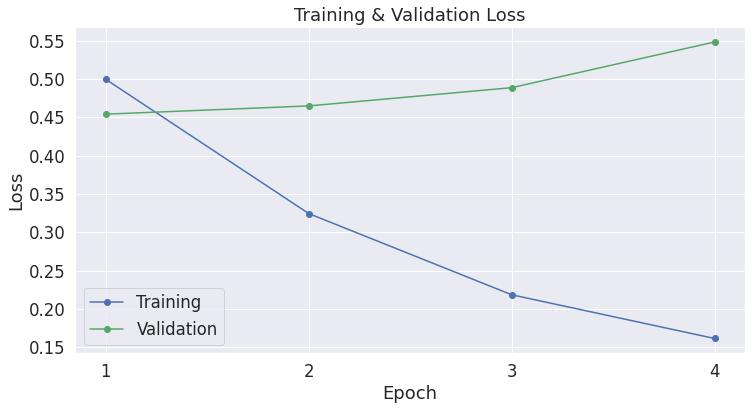

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# A.2. Test Score from Original Notebook


Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


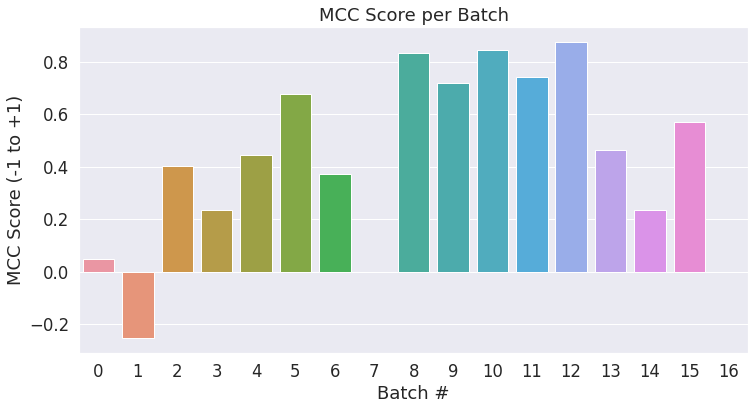

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.498


Cool! In about half an hour and without doing any hyperparameter tuning (adjusting the learning rate, epochs, batch size, ADAM properties, etc.) we are able to get a good score. 

> *Note: To maximize the score, we should remove the "validation set" (which we used to help determine how many epochs to train for) and train on the entire training set.*

The library documents the expected accuracy for this benchmark [here](https://huggingface.co/transformers/examples.html#glue) as `49.23`.

You can also look at the official leaderboard [here](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy). 

Note that (due to the small dataset size?) the accuracy can vary significantly between runs.
